### <u>Algorithm</u>
- Initialize the mean $\mu_k$, the covariance matrix $\Sigma_k$ and the mixing coefficients $\pi_k$ by some random values(or other values).
- Compute the $C_k$ values for all k.
- Again Estimate all the parameters using the current \C_k values.
- Compute log-likelihood function.
- Put some convergence criterion
- If the log-likelihood value converges to some value (or if all the parameters converge to some values) then stop, else return to Step 2.




In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from pandas import DataFrame 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

In [3]:
raw_df = pd.read_csv('Iris.csv')

raw_df.fillna(method ='ffill', inplace = True) 
raw_df.head(10)

C:\Users\ENG.SAHAR\AppData\Local\Temp\ipykernel_9544\2101001704.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw_df.fillna(method ='ffill', inplace = True)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
5,6,5.4,3.9,1.7,0.4,Iris-setosa
6,7,4.6,3.4,1.4,0.3,Iris-setosa
7,8,5.0,3.4,1.5,0.2,Iris-setosa
8,9,4.4,2.9,1.4,0.2,Iris-setosa
9,10,4.9,3.1,1.5,0.1,Iris-setosa


In [4]:
# Standardize data
le = LabelEncoder()
raw_df['species_encoded'] = le.fit_transform(raw_df['Species'])
data_numeric = raw_df.select_dtypes(include=[np.number])
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(data_numeric) 
  
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head(5)

,P1,P2
0,-1.089164,0.215666
1,-1.060291,-0.155563
2,-1.091925,-0.048398
3,-1.076030,-0.130868
4,-1.086956,0.259522


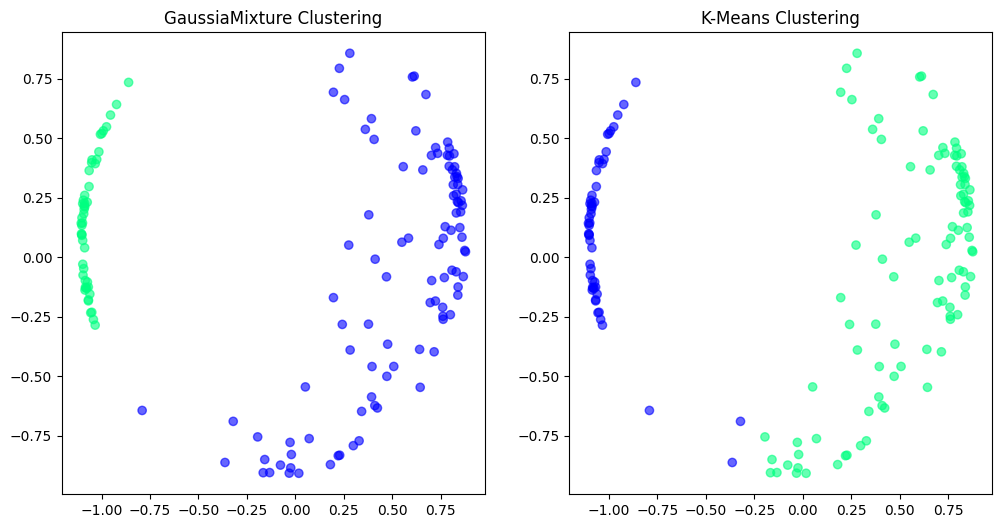

In [6]:
n_cluster= 2
gmm = GaussianMixture(n_cluster) 
gmm.fit(X_principal)
gmm_labels = gmm.fit_predict(X_principal)

kmeans = KMeans(n_cluster)
kmeans.fit(X_principal)
kmeans_labels = kmeans.fit_predict(X_principal)

# Visualizing the clustering 
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 6))
plt1.scatter(X_principal['P1'], X_principal['P2'],  
           c = GaussianMixture(n_cluster).fit_predict(X_principal), cmap =plt.cm.winter, alpha = 0.6) 
plt1.set_title('GaussiaMixture Clustering')

plt2.scatter(X_principal['P1'], X_principal['P2'],  
           c = KMeans(n_cluster).fit_predict(X_principal), cmap =plt.cm.winter, alpha = 0.6) 
plt2.set_title('K-Means Clustering')



plt.show()

### <u>Number of components(k) selection</u>:

#### <u>Silhouette score</u>
Silhouette score checks how much the clusters are compact and well separated. The more the score is near to one, the better the clustering is.

Since we already know that the fitting procedure is not deterministic, we run twenty fits for each number of clusters, then we consider the mean value and the standard deviation of the best five runs.

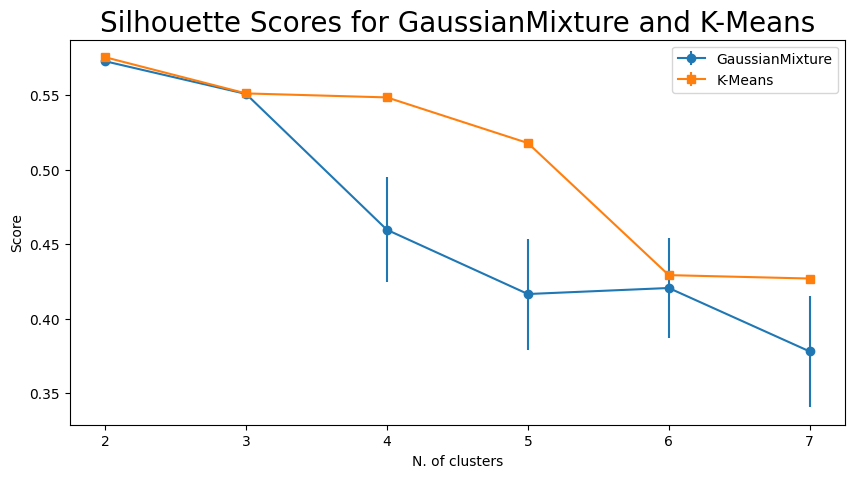

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import metrics

# دالة SelBest للاحتفاظ بأفضل التكرارات
def SelBest(arr: list, X: int) -> list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx = np.argsort(arr)[:X]
    return arr[dx]

# نطاق عدد المجموعات التي نريد تجربتها
n_clusters = np.arange(2, 8)
iterations = 20

# حساب Silhouette لـ GaussianMixture
gmm_sils = []
gmm_sils_err = []

for n in n_clusters:
    tmp_sil = []
    for _ in range(iterations):
        gmm = GaussianMixture(n, n_init=2).fit(X_principal)
        labels = gmm.predict(X_principal)
        sil = metrics.silhouette_score(X_principal, labels, metric='euclidean')
        tmp_sil.append(sil)
    val = np.mean(SelBest(np.array(tmp_sil), int(iterations / 5)))
    err = np.std(tmp_sil)
    gmm_sils.append(val)
    gmm_sils_err.append(err)

# حساب Silhouette لـ K-Means
kmeans_sils = []
kmeans_sils_err = []

for n in n_clusters:
    tmp_sil = []
    for _ in range(iterations):
        kmeans = KMeans(n_clusters=n, n_init=10, random_state=42).fit(X_principal)
        labels = kmeans.labels_
        sil = metrics.silhouette_score(X_principal, labels, metric='euclidean')
        tmp_sil.append(sil)
    val = np.mean(SelBest(np.array(tmp_sil), int(iterations / 5)))
    err = np.std(tmp_sil)
    kmeans_sils.append(val)
    kmeans_sils_err.append(err)

# رسم النتائج لـ GaussianMixture و K-Means
plt.figure(figsize=(10, 5))

# رسم GaussianMixture
plt.errorbar(n_clusters, gmm_sils, yerr=gmm_sils_err, label='GaussianMixture', marker='o')

# رسم K-Means
plt.errorbar(n_clusters, kmeans_sils, yerr=kmeans_sils_err, label='K-Means', marker='s')

plt.title("Silhouette Scores for GaussianMixture and K-Means", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()
plt.show()


<b><u>Bayesian information criterion (BIC)</u></b>

This criterion gives us an estimation on how much is good the GMM in terms of predicting the data we actually have. The lower is the BIC, the better is the model to actually predict the data we have. In order to avoid overfitting, this technique penalizes models with big number of clusters.

<b><u>AIC (Akaike Information Criterion)</b></u>

is a statistical measure used to evaluate how well a model fits the data while balancing model complexity. It is similar to the BIC (Bayesian Information Criterion) but follows a different approach.

Basic Concept:
AIC measures how well a model describes the data, considering the complexity of the model (i.e., the number of parameters used).
The lower the AIC value, the better the model is at balancing prediction accuracy and simplicity.
AIC aims to avoid overfitting, where a model is too complex and performs well on the training data but fails to generalize to new data.

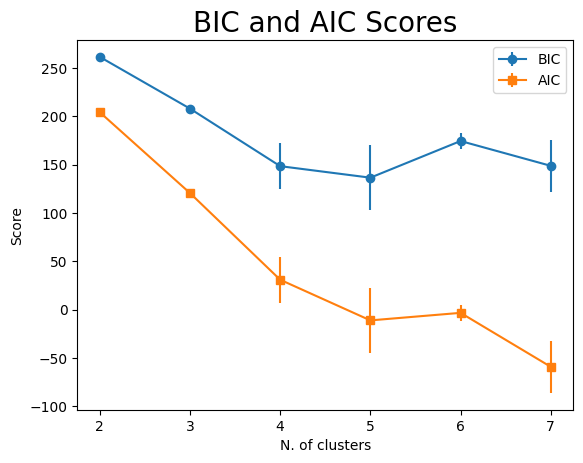

In [39]:
n_clusters = np.arange(2, 8)
bics = []
bics_err = []
aics = []
aics_err = []
iterations = 20

for n in n_clusters:
    tmp_bic = []
    tmp_aic = []
    for _ in range(iterations):
        gmm = GaussianMixture(n, n_init=2).fit(X_principal)
        
        tmp_bic.append(gmm.bic(X_principal))
        tmp_aic.append(gmm.aic(X_principal))
    
    # حساب القيم المتوسطة والانحراف المعياري
    val_bic = np.mean(SelBest(np.array(tmp_bic), int(iterations / 5)))
    err_bic = np.std(tmp_bic)
    bics.append(val_bic)
    bics_err.append(err_bic)
    
    val_aic = np.mean(SelBest(np.array(tmp_aic), int(iterations / 5)))
    err_aic = np.std(tmp_aic)
    aics.append(val_aic)
    aics_err.append(err_aic)

# رسم BIC و AIC على نفس الرسم البياني
plt.errorbar(n_clusters, bics, yerr=bics_err, label='BIC', fmt='-o')
plt.errorbar(n_clusters, aics, yerr=aics_err, label='AIC', fmt='-s')
plt.title("BIC and AIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()
plt.show()



<b><u>The Elbow Method </b></u>

is a technique used to determine the optimal number of clusters (K) when using the K-Means clustering algorithm. The main idea is to measure the Inertia or Sum of Squared Distances (SSD), which is the sum of the distances between each point and its assigned cluster center.

Steps of the method:
Apply the K-Means algorithm on the data with different numbers of clusters (K).
Calculate the Inertia for each number of clusters.
Plot a curve representing the relationship between the number of clusters and the Inertia value.

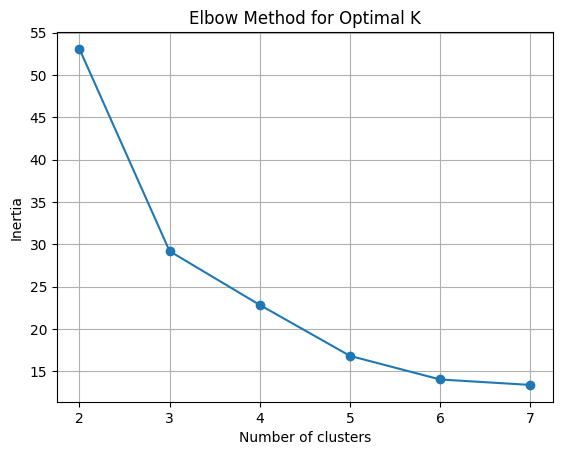

In [40]:

# نطاق عدد المجموعات الذي سيتم اختباره
n_clusters = np.arange(2, 8)
inertias = []

# حساب الـ Inertia لكل عدد من المجموعات
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_principal)
    inertias.append(kmeans.inertia_)

# رسم منحنى Elbow Method
plt.plot(n_clusters, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(n_clusters)
plt.grid(True)
plt.show()
